# Import packages

In [2]:
import pandas as pd 
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

# Data Preparation and Initial Exploration

## Utility functions

In [3]:
def fix_date_column(df, date_column='date'):
    """
    Fixes the date column format by parsing strings to datetime.
    """
    df[date_column] = df[date_column].astype(str)
    df[date_column] = df[date_column].apply(lambda x: parse(x))
    return df

def sigma_t2_Q2_2(x, alpha, beta, delta, omega, lamb):
    """
    Computes conditional volatility for different shocks for the News Impact Curve.
    """
    sigma2 = np.zeros(len(x) - 1)
    for t in range(1, len(x) - 1):
        indicator = 1 if x[t - 1] < 0 else 0
        numerator = alpha * x[t - 1]**2 + delta * x[t - 1]**2 * indicator
        denominator = 1 + (lamb * x[t - 1]**2)
        sigma2[t] = omega + numerator / denominator + beta * 1  # sigma_t-1 set to 1
    return sigma2[1:]

## Load and prepare data

In [4]:
# Load the data 
df = pd.read_csv('data-Stocks.csv')  

# Filter each stock 
df_KO = df[df['TICKER'] == 'KO'].copy()
df_JNJ = df[df['TICKER'] == 'JNJ'].copy()
df_MRK = df[df['TICKER'] == 'MRK'].copy()
df_PFE = df[df['TICKER'] == 'PFE'].copy()

# Preprocess returns: demean and scale by 100
for stock_df in [df_KO, df_JNJ, df_MRK, df_PFE]:
    stock_df['RET*'] = (stock_df['RET'] - stock_df['RET'].mean()) * 100

# Reset index 
df_KO = df_KO.reset_index(drop=True)
df_JNJ = df_JNJ.reset_index(drop=True)
df_MRK = df_MRK.reset_index(drop=True)
df_PFE = df_PFE.reset_index(drop=True)

# Fix date columns 
for stock_df in [df_KO, df_JNJ, df_MRK, df_PFE]:
    stock_df = fix_date_column(stock_df)

# See header of the dataframes
print(df_KO.head())
print(df_JNJ.head())
print(df_MRK.head())
print(df_PFE.head())

   PERMNO       date TICKER       RET      RET*
0   11308 2001-01-02     KO -0.002051 -0.236302
1   11308 2001-01-03     KO -0.025694 -2.600602
2   11308 2001-01-04     KO -0.028481 -2.879302
3   11308 2001-01-05     KO  0.002172  0.185998
4   11308 2001-01-08     KO  0.016251  1.593898
   PERMNO       date TICKER       RET      RET*
0   22111 2001-01-02    JNJ -0.029149 -2.954432
1   22111 2001-01-03    JNJ -0.031863 -3.225832
2   22111 2001-01-04    JNJ -0.021519 -2.191432
3   22111 2001-01-05    JNJ  0.012937  1.254168
4   22111 2001-01-08    JNJ -0.001277 -0.167232
   PERMNO       date TICKER       RET     RET*
0   22752 2001-01-02    MRK -0.006676 -0.69368
1   22752 2001-01-03    MRK -0.041667 -4.19278
2   22752 2001-01-04    MRK -0.046283 -4.65438
3   22752 2001-01-05    MRK -0.019853 -2.01138
4   22752 2001-01-08    MRK  0.002251  0.19902
   PERMNO       date TICKER       RET      RET*
0   21936 2001-01-02    PFE  0.002717  0.240411
1   21936 2001-01-03    PFE -0.055556 -5.58688

## News Impact curves

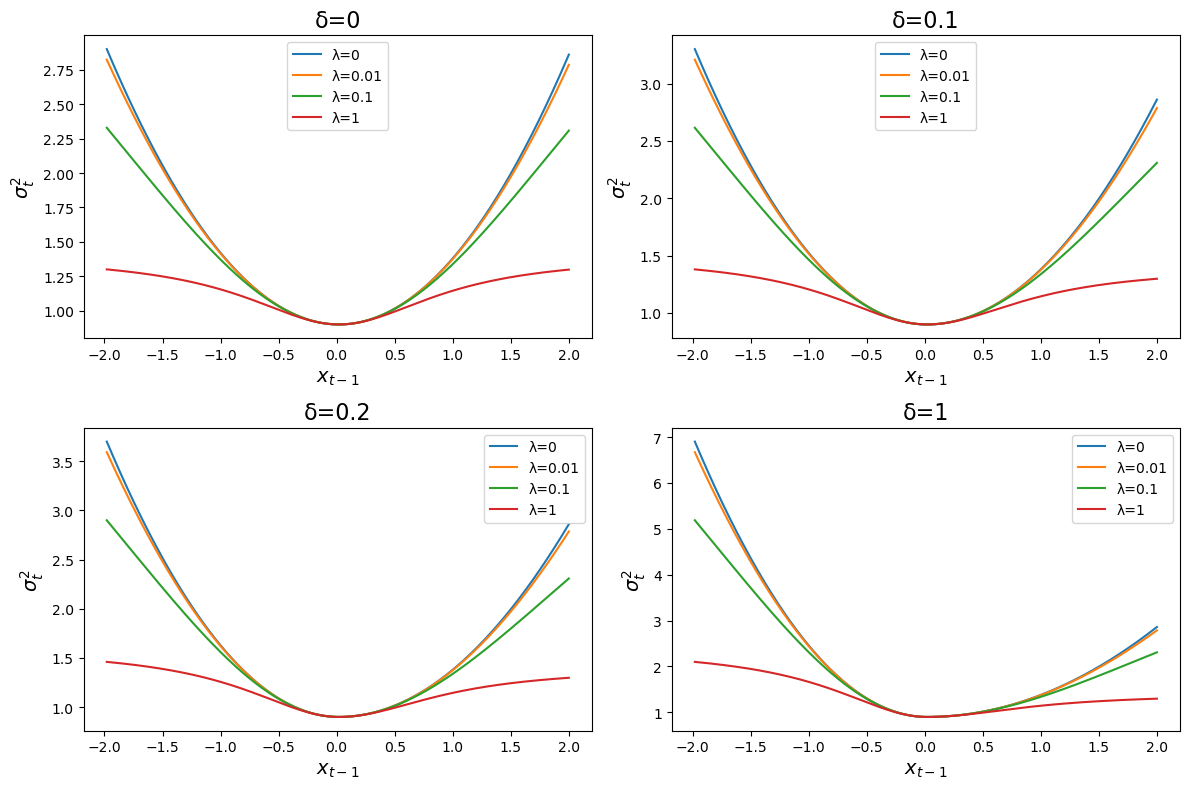

In [5]:
# Set parameters
omega = 0
alpha = 0.5
beta = 0.9
x = np.linspace(-2, 2, 400)
lambdas = [0, 0.01, 0.1, 1]
deltas = [0, 0.1, 0.2, 1]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, delta in enumerate(deltas):
    for lamb in lambdas:
        axes[i].plot(x[2:], sigma_t2_Q2_2(x, alpha, beta, delta, omega, lamb), label=f'λ={lamb}')
    axes[i].set_title(f'δ={delta}', fontsize=16)
    axes[i].legend()
    axes[i].set_xlabel(r'$x_{t-1}$', fontsize=14)
    axes[i].set_ylabel(r'$\sigma^2_t$', fontsize=14)

plt.tight_layout()
plt.show()


## Descriptive statistics

In [6]:
stock_dfs = [df_JNJ['RET*'], df_MRK['RET*'], df_PFE['RET*'], df_KO['RET*']]
stock_names = ['JNJ', 'MRK', 'PFE', 'KO']

for stock, name in zip(stock_dfs, stock_names):
    desc_stats = stock.describe().T
    desc_stats['skewness'] = stock.skew().round(2)
    desc_stats['excess kurtosis'] = stock.kurtosis().round(2)
    desc_stats = desc_stats[['count', 'mean', '50%', 'std', 'skewness', 'excess kurtosis', 'min', 'max']].round(2)
    desc_stats.columns = ['number of observations', 'mean', 'median', 'standard deviation',
                          'skewness', 'excess kurtosis', 'minimum', 'maximum']
    print(f"\nDescriptive statistics for {name}:\n")
    print(desc_stats)



Descriptive statistics for JNJ:

count              5284.00
mean                 -0.00
50%                  -0.01
std                   1.17
skewness             -0.26
excess kurtosis      14.90
min                 -15.89
max                  12.19
Name: RET*, dtype: float64

Descriptive statistics for MRK:

count              5284.00
mean                  0.00
50%                  -0.00
std                   1.65
skewness             -0.92
excess kurtosis      21.11
min                 -26.81
max                  13.01
Name: RET*, dtype: float64

Descriptive statistics for PFE:

count              5284.00
mean                  0.00
50%                  -0.03
std                   1.53
skewness             -0.02
excess kurtosis       6.07
min                 -11.18
max                  10.82
Name: RET*, dtype: float64

Descriptive statistics for KO:

count              5284.00
mean                  0.00
50%                   0.01
std                   1.22
skewness             -0.07
e

## Plot Time Series of Returns

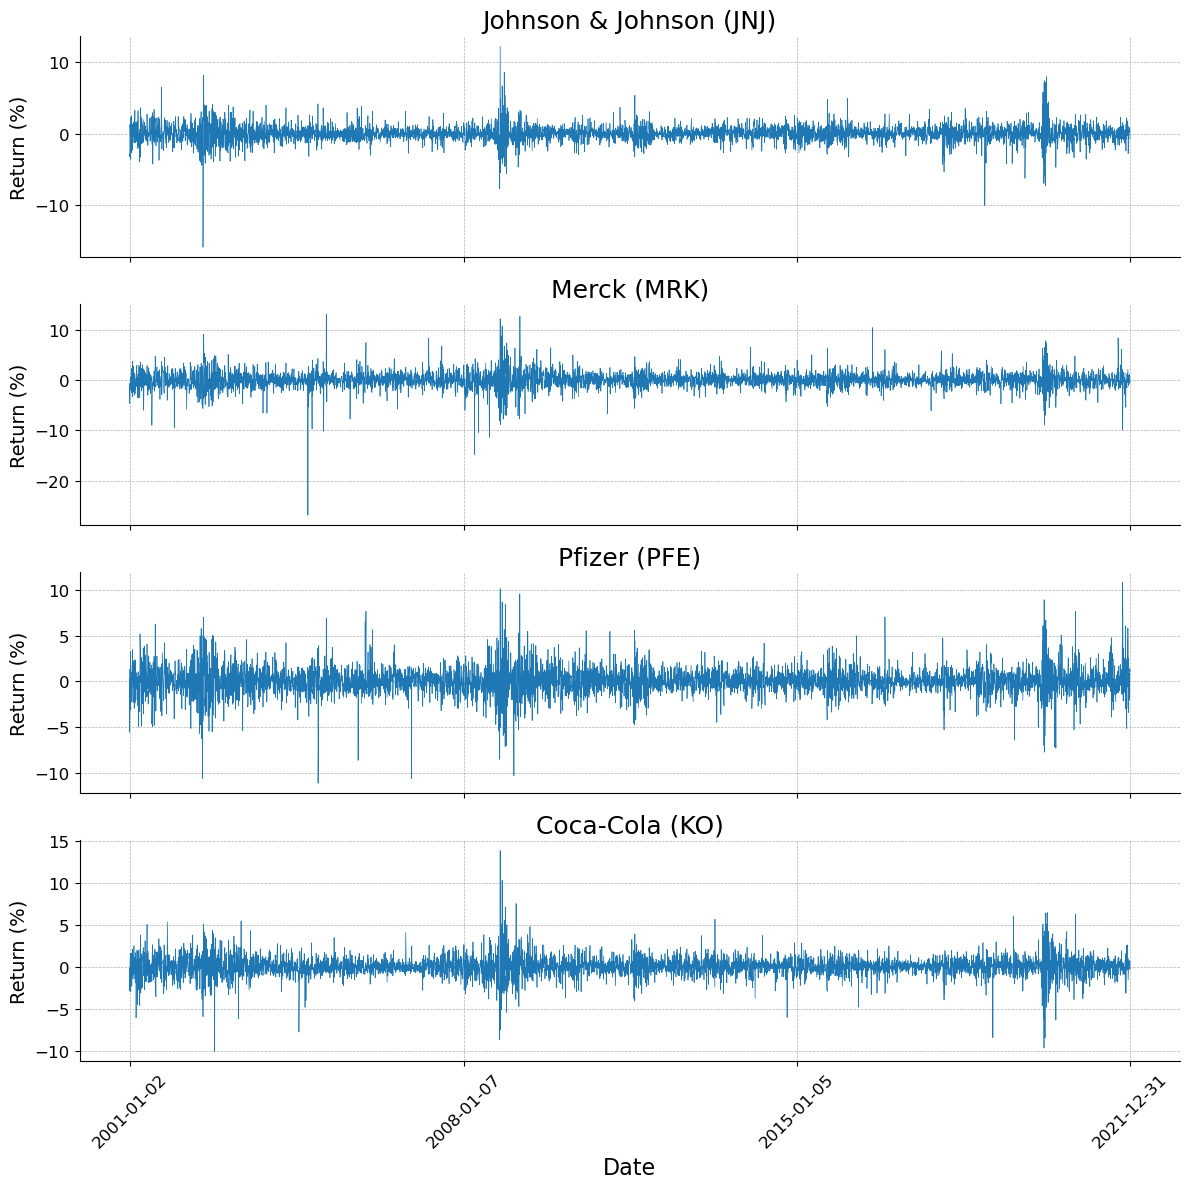

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

dfs = [df_JNJ, df_MRK, df_PFE, df_KO]
names = ['Johnson & Johnson (JNJ)', 'Merck (MRK)', 'Pfizer (PFE)', 'Coca-Cola (KO)']

for i, df in enumerate(dfs):
    axs[i].plot(df['date'], df['RET*'], label=f'{names[i]} Returns', linewidth=0.5)
    axs[i].set_title(names[i], fontsize=18)
    axs[i].set_ylabel('Return (%)', fontsize=14)
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='y', labelsize=12)

# Set x-ticks nicely
n = len(df_JNJ)
dates = [df_JNJ['date'].iloc[0],
         df_JNJ['date'].iloc[n // 3],
         df_JNJ['date'].iloc[2 * n // 3],
         df_JNJ['date'].iloc[-1]]

axs[-1].set_xticks(dates)
axs[-1].set_xticklabels([date.strftime('%Y-%m-%d') for date in dates], rotation=45, fontsize=12)
axs[-1].set_xlabel('Date', fontsize=16)

plt.tight_layout()
plt.show()


# Volatility Modeling: Robust GARCH Estimation


## Define model functions

In [8]:
import math
from scipy.optimize import minimize

# Define conditional volatility function
def sigma_t_2(x, alpha, beta, delta, omega, lamb):
    """
    Filters the conditional volatility series based on model parameters.
    """
    sigma2 = np.zeros(len(x) - 1)
    x50bar = np.sum(x[:50]) / 50
    sigma2[0] = np.sum((x[:50] - x50bar)**2) / 50

    for t in range(1, len(x) - 1):
        indicator = 1 if x[t-1] < 0 else 0
        numerator = alpha * x[t-1]**2 + delta * x[t-1]**2 * indicator
        denominator = 1 + (lamb * x[t-1]**2 / sigma2[t-1])
        sigma2[t] = omega + numerator / denominator + beta * sigma2[t-1]

    return sigma2
    
## Negative Log-Likelihoods for each model

def neg_LL_non_robust(theta, x):
    v, alpha, beta, omega = theta
    delta = 0
    lamb = 0

    x = np.asarray(x)
    sigma2 = sigma_t_2(x, alpha, beta, delta, omega, lamb)
    x = x[:len(x)-1]

    LogGamma = math.lgamma((v+1)/2) - (math.lgamma(v/2) + np.log(np.sqrt(v*np.pi)))
    epsilon = 1e-6  # numerical stability
    LL = LogGamma - (v+1)/2 * np.log(1 + (x**2 / sigma2) / v) - 0.5 * np.log(np.maximum(sigma2, epsilon))

    return np.sum(-LL)

def neg_LL_robust_no_leverage(theta, x):
    v, alpha, beta, omega, lamb = theta
    delta = 0

    x = np.asarray(x)
    sigma2 = sigma_t_2(x, alpha, beta, delta, omega, lamb)
    x = x[:len(x)-1]

    LogGamma = math.lgamma((v+1)/2) - (math.lgamma(v/2) + np.log(np.sqrt(v*np.pi)))
    epsilon = 1e-6
    LL = LogGamma - (v+1)/2 * np.log(1 + (x**2 / sigma2) / v) - 0.5 * np.log(np.maximum(sigma2, epsilon))
    penalty = 0.0001 * np.sum(np.maximum(-sigma2, 0))

    return np.sum(-LL) + penalty

def neg_LL_robust_with_leverage(theta, x):
    v, alpha, beta, delta, omega, lamb = theta

    x = np.asarray(x)
    sigma2 = sigma_t_2(x, alpha, beta, delta, omega, lamb)
    x = x[:len(x)-1]

    LogGamma = math.lgamma((v+1)/2) - (math.lgamma(v/2) + np.log(np.sqrt(v*np.pi)))
    epsilon = 1e-6
    LL = LogGamma - (v+1)/2 * np.log(1 + (x**2 / sigma2) / v) - 0.5 * np.log(np.maximum(sigma2, epsilon))
    penalty = 0.0001 * np.sum(np.maximum(-sigma2, 0))

    return np.sum(-LL) + penalty


## Estimate GARCH Models for Each Stock

In [9]:
# Prepare Data for Estimation
names = ['JNJ', 'MRK', 'PFE', 'KO']
data = [df_JNJ['RET*'][:2500], df_MRK['RET*'][:2500], df_PFE['RET*'][:2500], df_KO['RET*'][:2500]]

# Estimate Non-Robust GARCH Model (lambda=0, delta=0) 
print('Optimal results for Non-Robust GARCH (no robustness, no leverage):\n')

for x, name in zip(data, names):
    omega = ((x - x.mean())**2).mean() / 50
    bounds = [(1e-9, None), (0, None), (0, None), (1e-9, None)]
    theta0 = np.array([10, 0.02, 0.96, omega])

    result = minimize(neg_LL_non_robust, x0=theta0, args=x.values, bounds=bounds)

    if result.success:
        params = result.x
        LL = -result.fun
        AIC = 2 * len(theta0) - 2 * LL
        BIC = -2 * LL + len(theta0) * np.log(len(x))

        print(f"Stock: {name}")
        print(f"v = {params[0]:.3f}, alpha = {params[1]:.3f}, beta = {params[2]:.3f}, omega = {params[3]:.5f}")
        print(f"Log-Likelihood = {LL:.2f}, AIC = {AIC:.2f}, BIC = {BIC:.2f}\n")
    else:
        print(f"Optimization for {name} did not converge.\n")


Optimal results for Non-Robust GARCH (no robustness, no leverage):

Stock: JNJ
v = 5.545, alpha = 0.065, beta = 0.886, omega = 0.01446
Log-Likelihood = -3572.54, AIC = 7153.08, BIC = 7176.38

Stock: MRK
v = 4.154, alpha = 0.060, beta = 0.831, omega = 0.10055
Log-Likelihood = -4706.55, AIC = 9421.09, BIC = 9444.39

Stock: PFE
v = 5.984, alpha = 0.052, beta = 0.900, omega = 0.04004
Log-Likelihood = -4556.56, AIC = 9121.12, BIC = 9144.42

Stock: KO
v = 5.324, alpha = 0.033, beta = 0.942, omega = 0.00647
Log-Likelihood = -3785.63, AIC = 7579.25, BIC = 7602.55



## Estimate Robust GARCH (No Leverage)

In [10]:
# Estimate Robust GARCH (lambda ≠ 0, delta = 0) 
print('Optimal results for Robust GARCH (no leverage):\n')

for x, name in zip(data, names):
    omega = ((x - x.mean())**2).mean() / 50
    bounds = [(1e-9, None), (0, None), (0, None), (1e-9, None), (1e-9, None)]
    theta0 = np.array([10, 0.02, 0.96, omega, 0])

    result = minimize(neg_LL_robust_no_leverage, x0=theta0, args=x.values, bounds=bounds)

    if result.success:
        params = result.x
        LL = -result.fun
        AIC = 2 * len(theta0) - 2 * LL
        BIC = -2 * LL + len(theta0) * np.log(len(x))

        print(f"Stock: {name}")
        print(f"v = {params[0]:.3f}, alpha = {params[1]:.3f}, beta = {params[2]:.3f}, omega = {params[3]:.5f}, lambda = {params[4]:.3f}")
        print(f"Log-Likelihood = {LL:.2f}, AIC = {AIC:.2f}, BIC = {BIC:.2f}\n")
    else:
        print(f"Optimization for {name} did not converge.\n")


Optimal results for Robust GARCH (no leverage):

Stock: JNJ
v = 5.778, alpha = 0.131, beta = 0.860, omega = 0.01326, lambda = 0.117
Log-Likelihood = -3565.99, AIC = 7141.98, BIC = 7171.10

Stock: MRK
v = 4.260, alpha = 0.106, beta = 0.854, omega = 0.05071, lambda = 0.094
Log-Likelihood = -4682.02, AIC = 9374.03, BIC = 9403.15

Stock: PFE
v = 6.196, alpha = 0.122, beta = 0.881, omega = 0.02905, lambda = 0.171
Log-Likelihood = -4541.42, AIC = 9092.84, BIC = 9121.96

Stock: KO
v = 5.563, alpha = 0.105, beta = 0.909, omega = 0.00565, lambda = 0.198
Log-Likelihood = -3773.05, AIC = 7556.10, BIC = 7585.22



## Estimate Robust GARCH with Leverage

In [11]:
def neg_LL_non_robust(theta, x):
    v, alpha, beta, omega = theta
    delta = 0
    lamb = 0

    x = np.asarray(x)
    sigma2 = sigma_t_2(x, alpha, beta, delta, omega, lamb)
    x = x[:len(x)-1]

    LogGamma = math.lgamma((v+1)/2) - (math.lgamma(v/2) + np.log(np.sqrt(v*np.pi)))
    epsilon = 1e-6  # numerical stability
    LL = LogGamma - (v+1)/2 * np.log(1 + (x**2 / sigma2) / v) - 0.5 * np.log(np.maximum(sigma2, epsilon))

    return np.sum(-LL)

def neg_LL_robust_no_leverage(theta, x):
    v, alpha, beta, omega, lamb = theta
    delta = 0

    x = np.asarray(x)
    sigma2 = sigma_t_2(x, alpha, beta, delta, omega, lamb)
    x = x[:len(x)-1]

    LogGamma = math.lgamma((v+1)/2) - (math.lgamma(v/2) + np.log(np.sqrt(v*np.pi)))
    epsilon = 1e-6
    LL = LogGamma - (v+1)/2 * np.log(1 + (x**2 / sigma2) / v) - 0.5 * np.log(np.maximum(sigma2, epsilon))
    penalty = 0.0001 * np.sum(np.maximum(-sigma2, 0))

    return np.sum(-LL) + penalty

def neg_LL_robust_with_leverage(theta, x):
    v, alpha, beta, delta, omega, lamb = theta

    x = np.asarray(x)
    sigma2 = sigma_t_2(x, alpha, beta, delta, omega, lamb)
    x = x[:len(x)-1]

    LogGamma = math.lgamma((v+1)/2) - (math.lgamma(v/2) + np.log(np.sqrt(v*np.pi)))
    epsilon = 1e-6
    LL = LogGamma - (v+1)/2 * np.log(1 + (x**2 / sigma2) / v) - 0.5 * np.log(np.maximum(sigma2, epsilon))
    penalty = 0.0001 * np.sum(np.maximum(-sigma2, 0))

    return np.sum(-LL) + penalty


In [12]:
# Estimate Robust GARCH with Leverage (lambda ≠ 0, delta ≠ 0) 
print('Optimal results for Robust GARCH with Leverage:\n')

for x, name in zip(data, names):
    omega = ((x - x.mean())**2).mean() / 50
    bounds = [(1e-9, None), (0, None), (0, None), (0, None), (1e-9, None), (1e-9, None)]
    theta0 = np.array([10, 0.02, 0.96, 0, omega, 0])

    result = minimize(neg_LL_robust_with_leverage, x0=theta0, args=(x.values,), bounds=bounds)

    if result.success:
        params = result.x
        LL = -result.fun
        AIC = 2 * len(theta0) - 2 * LL
        BIC = -2 * LL + len(theta0) * np.log(len(x))

        print(f"Stock: {name}")
        print(f"v = {params[0]:.3f}, alpha = {params[1]:.3f}, beta = {params[2]:.3f}, delta = {params[3]:.3f}, omega = {params[4]:.5f}, lambda = {params[5]:.3f}")
        print(f"Log-Likelihood = {LL:.2f}, AIC = {AIC:.2f}, BIC = {BIC:.2f}\n")
    else:
        print(f"Optimization for {name} did not converge.\n")


Optimal results for Robust GARCH with Leverage:

Stock: JNJ
v = 6.164, alpha = 0.033, beta = 0.883, delta = 0.143, omega = 0.01305, lambda = 0.100
Log-Likelihood = -3547.72, AIC = 7107.44, BIC = 7142.38

Stock: MRK
v = 4.312, alpha = 0.034, beta = 0.888, delta = 0.128, omega = 0.03546, lambda = 0.156
Log-Likelihood = -4669.28, AIC = 9350.56, BIC = 9385.50

Stock: PFE
v = 6.195, alpha = 0.046, beta = 0.908, delta = 0.180, omega = 0.01392, lambda = 0.394
Log-Likelihood = -4529.99, AIC = 9071.99, BIC = 9106.93

Stock: KO
v = 5.842, alpha = 0.018, beta = 0.928, delta = 0.096, omega = 0.00735, lambda = 0.104
Log-Likelihood = -3757.05, AIC = 7526.09, BIC = 7561.04



## Plot News Impact Curves for Three Models

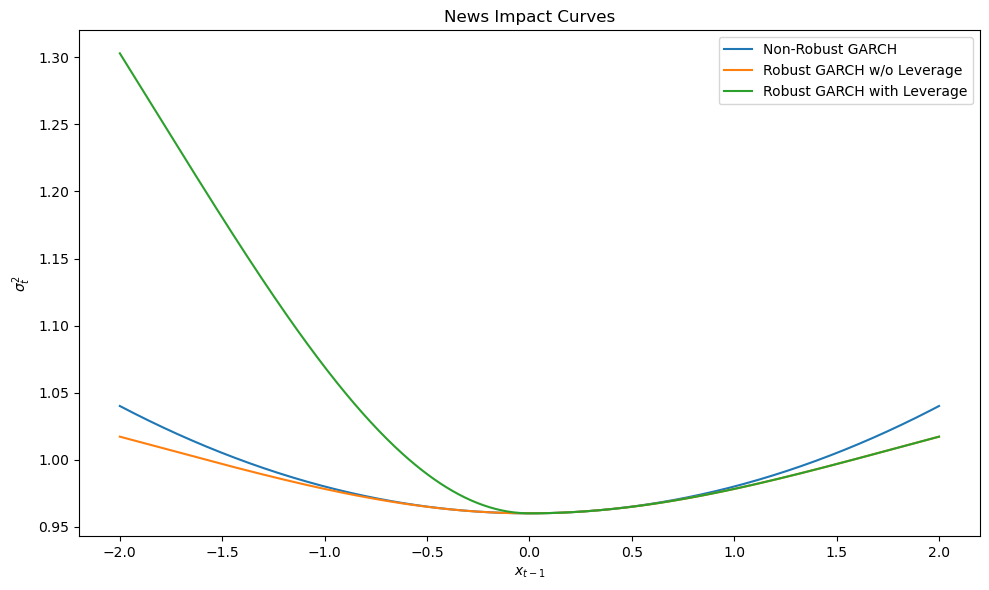

In [13]:
# Plot News Impact Curves for: Non-Robust, Robust (no leverage), Robust (with leverage) models

# Suppose results_i, results_ii, results_iii are the best results for one selected stock (example: JNJ)

def sigma_t2_news_plot(x, alpha, beta, delta, omega, lamb, model_type):
    sigma2 = np.zeros(len(x))
    for t in range(len(x)):
        indicator = 1 if x[t] < 0 else 0
        if model_type == 'non-robust':
            sigma2[t] = omega + alpha * x[t]**2 + beta * 1
        elif model_type == 'robust_no_leverage':
            numerator = alpha * x[t]**2
            denominator = 1 + (lamb * x[t]**2)
            sigma2[t] = omega + numerator / denominator + beta * 1
        elif model_type == 'robust_with_leverage':
            numerator = alpha * x[t]**2 + delta * x[t]**2 * indicator
            denominator = 1 + (lamb * x[t]**2)
            sigma2[t] = omega + numerator / denominator + beta * 1
    return sigma2

# Example x values
x = np.linspace(-2, 2, 400)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, sigma_t2_news_plot(x, 0.02, 0.96, 0, 0.0001, 0, 'non-robust'), label='Non-Robust GARCH')
ax.plot(x, sigma_t2_news_plot(x, 0.02, 0.96, 0, 0.0001, 0.1, 'robust_no_leverage'), label='Robust GARCH w/o Leverage')
ax.plot(x, sigma_t2_news_plot(x, 0.02, 0.96, 0.1, 0.0001, 0.1, 'robust_with_leverage'), label='Robust GARCH with Leverage')

ax.set_title('News Impact Curves')
ax.set_xlabel(r'$x_{t-1}$')
ax.set_ylabel(r'$\sigma_t^2$')
ax.legend()
plt.tight_layout()
plt.show()


# Hypothesis Testing: Robustness and Leverage Effects

In [ ]:
# Import missing functions
import numpy as np
from scipy.optimize import minimize, approx_fprime
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define numerical Hessian approximation
def hessian_2sided(fun, x0, *args, epsilon=1e-5):
    n = x0.shape[0]
    hess = np.zeros((n, n))
    fx = fun(x0, *args)
    for i in range(n):
        x1 = x0.copy()
        x2 = x0.copy()
        x1[i] += epsilon
        x2[i] -= epsilon
        grad1 = approx_fprime(x1, fun, epsilon, *args)
        grad2 = approx_fprime(x2, fun, epsilon, *args)
        hess[:, i] = (grad1 - grad2) / (2 * epsilon)
    return hess


names = ['JNJ', 'MRK', 'PFE', 'KO']
datasets = [df_JNJ['RET*'][:2500], df_MRK['RET*'][:2500], df_PFE['RET*'][:2500], df_KO['RET*'][:2500]]

for x, name in zip(datasets, names):
    v = 10
    omega = ((x - x.mean()) ** 2).mean() / 50
    bounds = [(1e-9, None), (0, None), (0, None), (0, None), (1e-9, None), (1e-9, None)]
    theta0 = np.array([v, 0.02, 0.96, 0, omega, 0])

    result = minimize(neg_LL_robust_with_leverage, x0=theta0, args=(x.values,), bounds=bounds)

    if result.success:
        Hessian = hessian_2sided(neg_LL_robust_with_leverage, result.x, x.values)
        InvHessian = np.linalg.inv(Hessian)
        stderrs = np.sqrt(np.diag(InvHessian))

        # Wald tests
        W_delta = result.x[3] / stderrs[3]
        p_value_delta = 2 * (1 - norm.cdf(np.abs(W_delta)))

        W_lambda = result.x[5] / stderrs[5]
        p_value_lambda = 2 * (1 - norm.cdf(np.abs(W_lambda)))

        print(f'For {name}:')
        print(f'  p-value for leverage effect (delta ≠ 0): {p_value_delta:.5f}')
        print(f'  p-value for robustness (lambda ≠ 0): {p_value_lambda:.5f}')
        print(f'  Estimated degrees of freedom: {result.x[0]:.3f}')
        print('_' * 80)
    else:
        print(f"Optimization for {name} did not converge.")


For JNJ:
  p-value for leverage effect (delta ≠ 0): 0.00008
  p-value for robustness (lambda ≠ 0): 0.09460
  Estimated degrees of freedom: 6.164
________________________________________________________________________________
For MRK:
  p-value for leverage effect (delta ≠ 0): 0.00071
  p-value for robustness (lambda ≠ 0): 0.01801
  Estimated degrees of freedom: 4.312
________________________________________________________________________________
For PFE:
  p-value for leverage effect (delta ≠ 0): 0.01522
  p-value for robustness (lambda ≠ 0): 0.10627
  Estimated degrees of freedom: 6.195
________________________________________________________________________________
For KO:
  p-value for leverage effect (delta ≠ 0): 0.00006
  p-value for robustness (lambda ≠ 0): 0.05317
  Estimated degrees of freedom: 5.842
________________________________________________________________________________


# Plotting News Impact Curves and Filtered Volatility

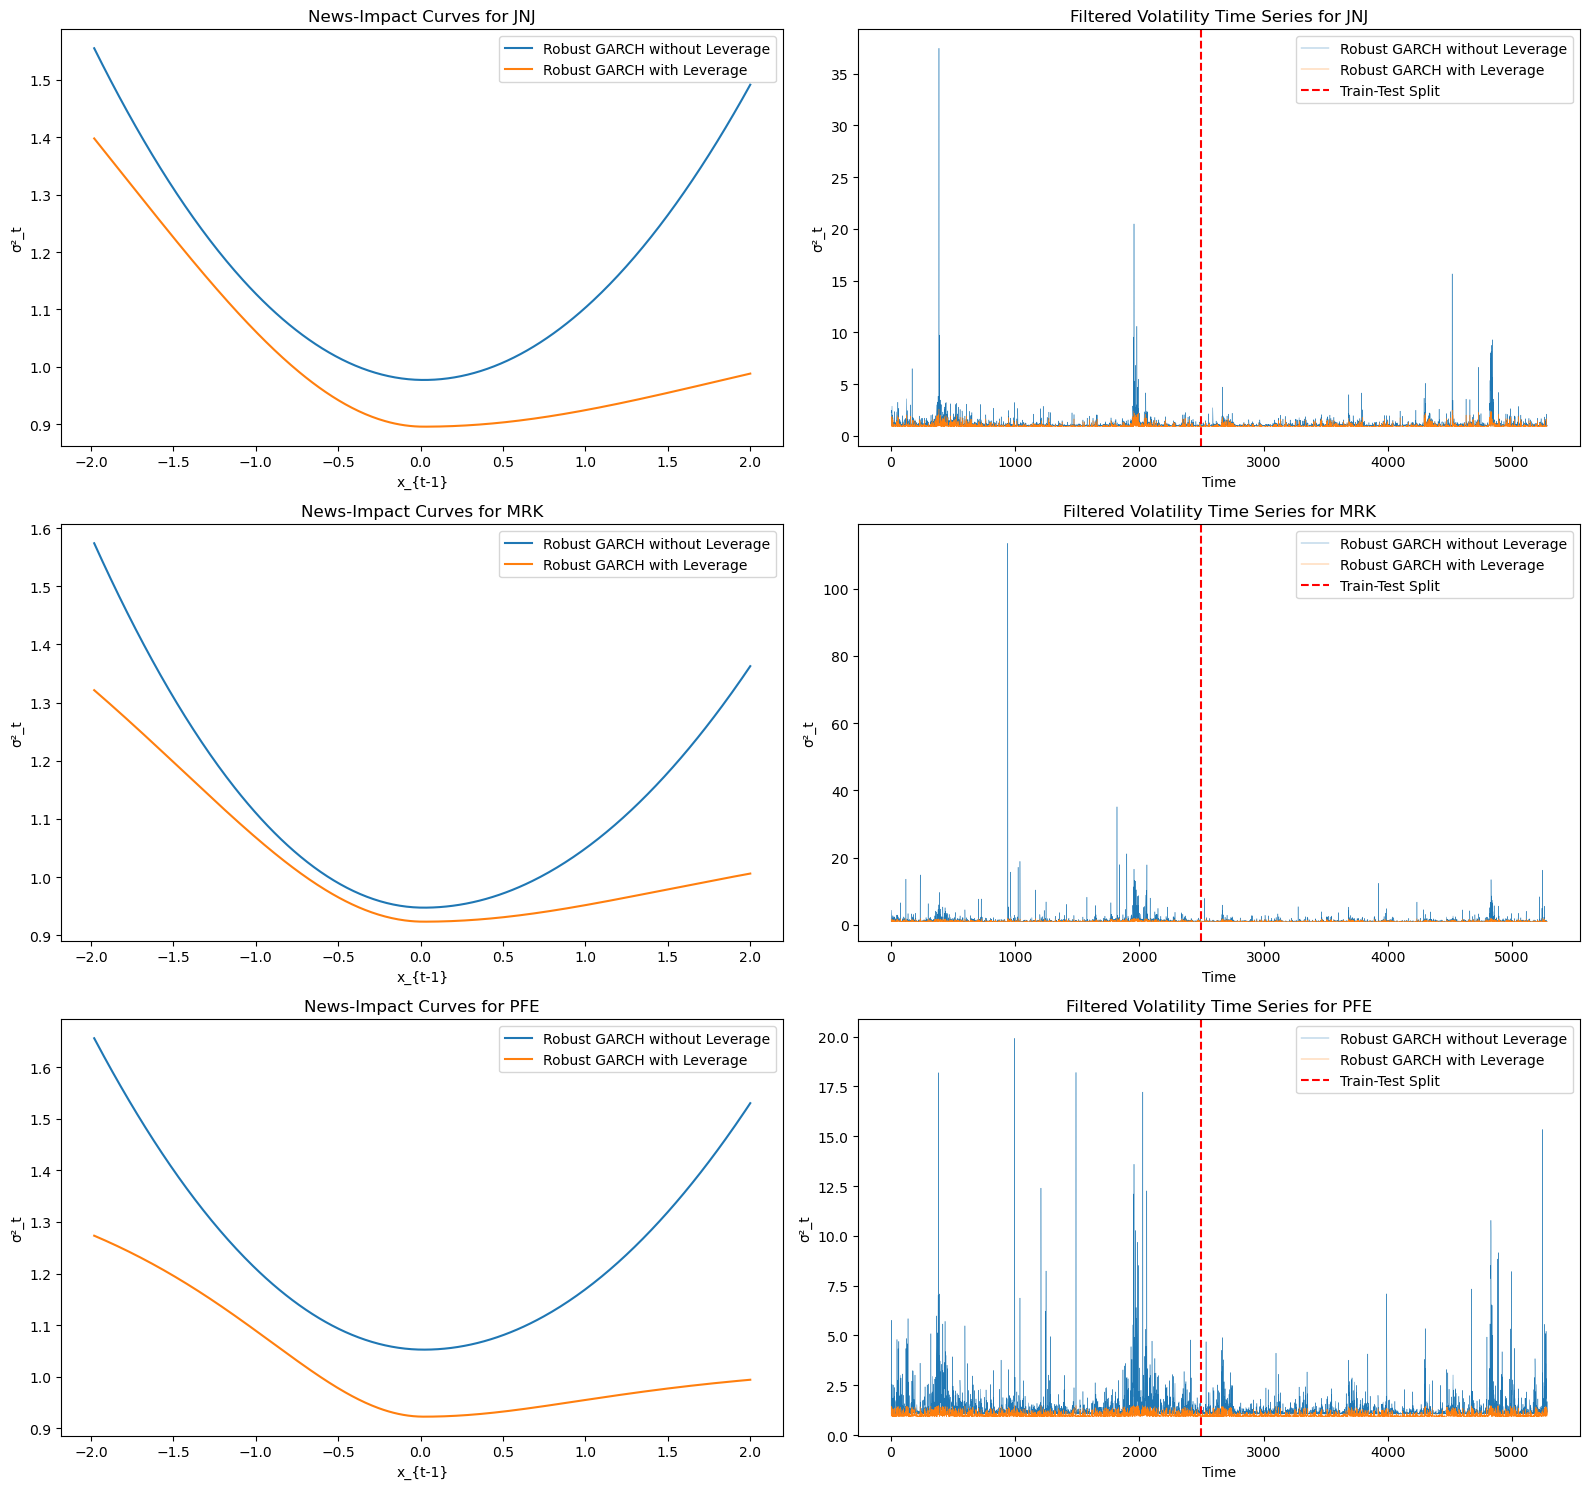

In [ ]:
# Only for JNJ, MRK, and PFE (KO is left out from this part)
stock_names = ['JNJ', 'MRK', 'PFE']
stock_data = [df_JNJ['RET*'], df_MRK['RET*'], df_PFE['RET*']]

fig, axes = plt.subplots(3, 2, figsize=(16, 15))

for i, (x, name) in enumerate(zip(stock_data, stock_names)):
    # Full model (robust with leverage)
    omega = ((x - x.mean())**2).mean() / 50
    theta0_full = np.array([10, 0.02, 0.96, 0, omega, 0])
    bounds_full = [(1e-9, None), (0, None), (0, None), (0, None), (1e-9, None), (1e-9, None)]
    result_full = minimize(neg_LL_robust_with_leverage, x0=theta0_full, args=(x[:2500].values,), bounds=bounds_full)

    # Reduced model (robust without leverage)
    theta0_reduced = np.array([10, 0.02, 0.96, omega, 0])
    bounds_reduced = [(1e-9, None), (0, None), (0, None), (1e-9, None), (1e-9, None)]
    result_reduced = minimize(neg_LL_robust_no_leverage, x0=theta0_reduced, args=(x[:2500].values,), bounds=bounds_reduced)

    # Extract parameters
    params_full = result_full.x
    params_reduced = result_reduced.x

    # News Impact Curves
    x_vals = np.linspace(-2, 2, 400)

    axes[i, 0].plot(
        x_vals[2:], sigma_t2_Q2_2(x_vals, params_reduced[1], params_reduced[2], params_reduced[3], params_reduced[4], 0),
        label='Robust GARCH without Leverage'
    )
    axes[i, 0].plot(
        x_vals[2:], sigma_t2_Q2_2(x_vals, params_full[1], params_full[2], params_full[3], params_full[4], params_full[5]),
        label='Robust GARCH with Leverage'
    )
    axes[i, 0].legend()
    axes[i, 0].set_xlabel('x_{t-1}')
    axes[i, 0].set_ylabel('σ²_t')
    axes[i, 0].set_title(f'News-Impact Curves for {name}')

    # Filtered Volatility Time Series
    time = x.index
    axes[i, 1].plot(
        time[2:], sigma_t2_Q2_2(x.values, params_reduced[1], params_reduced[2], params_reduced[3], params_reduced[4], 0),
        label='Robust GARCH without Leverage', lw=0.3
    )
    axes[i, 1].plot(
        time[2:], sigma_t2_Q2_2(x.values, params_full[1], params_full[2], params_full[3], params_full[4], params_full[5]),
        label='Robust GARCH with Leverage', lw=0.3
    )
    axes[i, 1].axvline(x.index[2500], color='red', linestyle='--', label='Train-Test Split')
    axes[i, 1].legend()
    axes[i, 1].set_xlabel('Time')
    axes[i, 1].set_ylabel('σ²_t')
    axes[i, 1].set_title(f'Filtered Volatility Time Series for {name}')

plt.tight_layout()
plt.show()


# Value-at-Risk (VaR) Simulation

In [ ]:
from scipy.optimize import minimize
from scipy.stats import t

# Define stocks and data
names = ['JNJ', 'MRK', 'PFE', 'KO']
data = [df_JNJ, df_MRK, df_PFE, df_KO]

# Loop through each stock
for i, (df, name) in enumerate(zip(data, names)):
    x = df['RET*'].reset_index(drop=True)

    v = 10
    bounds_full = [(1e-9, None), (0, None), (0, None), (0, None), (1e-9, None), (1e-9, None)]
    bounds_reduced = [(1e-9, None), (0, None), (0, None), (1e-9, None)]

    omega = ((x[:2500] - x[:2500].mean())**2).mean() / 50
    theta0_full = np.array([v, 0.02, 0.96, 0, omega, 0])

    result_full = minimize(neg_LL_robust_with_leverage, x0=theta0_full, args=(x[:2500].values,), bounds=bounds_full)
    result_reduced = minimize(neg_LL_non_robust, x0=np.array([v, 0.02, 0.96, omega]), args=(x[:2500].values,), bounds=bounds_reduced)

    # Extract full model parameters
    v_Full, alpha_Full, beta_Full, delta_Full, omega_Full, lamb_Full = result_full.x
    v_Reduced, alpha_Reduced, beta_Reduced, omega_Reduced = result_reduced.x
    delta_Reduced = 0
    lamb_Reduced = 0

    # Simulate volatility paths
    sigma2_Full = np.zeros(21)
    sigma2_Reduced = np.zeros(21)
    sigma2_Full[0] = sigma_t_2(x, alpha_Full, beta_Full, delta_Full, omega_Full, lamb_Full)[df[df['date'] == '2021-01-04'].index[0]]
    sigma2_Reduced[0] = sigma_t_2(x, alpha_Reduced, beta_Reduced, delta_Reduced, omega_Reduced, lamb_Reduced)[df[df['date'] == '2021-01-04'].index[0]]

    x_t0 = df.loc[df['date'] == '2021-01-04', 'RET*'].iloc[0]
    S = 10000

    x_1d_Full = np.zeros(S)
    x_5d_Full = np.zeros(S)
    x_20d_Full = np.zeros(S)

    x_1d_Reduced = np.zeros(S)
    x_5d_Reduced = np.zeros(S)
    x_20d_Reduced = np.zeros(S)

    for s in range(S):
        y = np.zeros(21)
        y[0] = x_t0

        eps = t.rvs(df=v_Full, size=21)

        for j in range(20):
            indicator = 1 if y[j] < 0 else 0
            numerator = alpha_Full * y[j]**2 + delta_Full * y[j]**2 * indicator
            denominator = 1 + (lamb_Full * y[j]**2 / sigma2_Full[j])
            sigma2_Full[j+1] = omega_Full + numerator / denominator + beta_Full * sigma2_Full[j]
            y[j+1] = np.sqrt(sigma2_Full[j+1]) * eps[j+1]

        x_1d_Full[s] = y[1]
        x_5d_Full[s] = 100 * (np.prod(1 + y[1:6]/100) - 1)
        x_20d_Full[s] = 100 * (np.prod(1 + y[1:21]/100) - 1)

        # Simulate Reduced model
        eps = t.rvs(df=v_Reduced, size=21)
        sigma2_Reduced = np.zeros(21)
        sigma2_Reduced[0] = sigma_t_2(x, alpha_Reduced, beta_Reduced, delta_Reduced, omega_Reduced, lamb_Reduced)[df[df['date'] == '2021-01-04'].index[0]]
        y = np.zeros(21)
        y[0] = x_t0

        for j in range(20):
            indicator = 1 if y[j] < 0 else 0
            numerator = alpha_Reduced * y[j]**2 + delta_Reduced * y[j]**2 * indicator
            denominator = 1 + (lamb_Reduced * y[j]**2 / sigma2_Reduced[j])
            sigma2_Reduced[j+1] = omega_Reduced + numerator / denominator + beta_Reduced * sigma2_Reduced[j]
            y[j+1] = np.sqrt(sigma2_Reduced[j+1]) * eps[j+1]

        x_1d_Reduced[s] = y[1]
        x_5d_Reduced[s] = 100 * (np.prod(1 + y[1:6]/100) - 1)
        x_20d_Reduced[s] = 100 * (np.prod(1 + y[1:21]/100) - 1)

    # Calculate Value-at-Risk
    confidence_levels = [0.01, 0.05, 0.10]
    forecast_days = ["1d", "5d", "20d"]

    forecast_vars = {
        "1d": {"Full": x_1d_Full, "Reduced": x_1d_Reduced},
        "5d": {"Full": x_5d_Full, "Reduced": x_5d_Reduced},
        "20d": {"Full": x_20d_Full, "Reduced": x_20d_Reduced}
    }

    var_values = {}

    for day in forecast_days:
        var_values[day] = {}
        for model in ["Full", "Reduced"]:
            var_values[day][model] = {}
            for level in confidence_levels:
                var_values[day][model][level] = np.percentile(forecast_vars[day][model], 100 * level / 2)

    # Print VaR Results
    print(f"\nValue-at-Risk Estimates for {name}:")
    for day, models in var_values.items():
        for model, levels in models.items():
            for level, value in levels.items():
                print(f"{name} {day} {model} VaR at {level*100}%: {value:.3f}")



Value-at-Risk Estimates for JNJ:
JNJ 1d Full VaR at 1.0%: -2.628
JNJ 1d Full VaR at 5.0%: -1.835
JNJ 1d Full VaR at 10.0%: -1.443
JNJ 1d Reduced VaR at 1.0%: -3.016
JNJ 1d Reduced VaR at 5.0%: -2.004
JNJ 1d Reduced VaR at 10.0%: -1.605
JNJ 5d Full VaR at 1.0%: -6.508
JNJ 5d Full VaR at 5.0%: -4.476
JNJ 5d Full VaR at 10.0%: -3.503
JNJ 5d Reduced VaR at 1.0%: -6.628
JNJ 5d Reduced VaR at 5.0%: -4.493
JNJ 5d Reduced VaR at 10.0%: -3.581
JNJ 20d Full VaR at 1.0%: -14.052
JNJ 20d Full VaR at 5.0%: -9.069
JNJ 20d Full VaR at 10.0%: -7.063
JNJ 20d Reduced VaR at 1.0%: -13.828
JNJ 20d Reduced VaR at 5.0%: -9.055
JNJ 20d Reduced VaR at 10.0%: -7.325

Value-at-Risk Estimates for MRK:
MRK 1d Full VaR at 1.0%: -4.121
MRK 1d Full VaR at 5.0%: -2.491
MRK 1d Full VaR at 10.0%: -1.929
MRK 1d Reduced VaR at 1.0%: -4.038
MRK 1d Reduced VaR at 5.0%: -2.535
MRK 1d Reduced VaR at 10.0%: -1.965
MRK 5d Full VaR at 1.0%: -8.987
MRK 5d Full VaR at 5.0%: -5.959
MRK 5d Full VaR at 10.0%: -4.746
MRK 5d Reduced 

# Backtesting the forecasts

In [ ]:
from scipy import stats

def backtest_forecast(data, tickers, confidence_levels=[0.01, 0.05, 0.10], window_size=2500, L=10):
    for tick in tickers:
        for level in confidence_levels:
            print(f"\nBacktesting for stock {tick} at {level*100}% confidence level:")

            data_series = data[tick]
            adjusted_forecast_data = data_series[window_size-1:].reset_index(drop=True)
            rolling_mean = data_series.rolling(window=window_size).mean().dropna()
            rolling_variance = data_series.rolling(window=window_size).var().dropna()

            VaRList = - stats.norm.ppf(level, loc=rolling_mean, scale=np.sqrt(rolling_variance))

            # Identify violations
            violations = [(f < v) for f, v in zip(adjusted_forecast_data, VaRList)]
            hit_rate = sum(violations) / len(violations)

            # Newey-West Standard Error
            H = len(adjusted_forecast_data)
            y_t = np.array(violations)
            s_NW_square = (1/H) * np.sum(y_t**2) + (2/H) * np.sum([(1 - l/(L+1)) * np.dot(y_t[l:H], y_t[:H-l]) for l in range(1, L+1)])
            se_NW = np.sqrt(s_NW_square) / np.sqrt(H)
            se_standard = np.std(violations) / np.sqrt(H)

            print(f"Hit rate = {hit_rate:.5f}")
            print(f"Newey-West standard error = {se_NW:.5f}")
            print(f"Standard error = {se_standard:.5f}")

# Create DataFrame for backtesting
tickers = ['JNJ', 'MRK', 'PFE', 'KO']
df_backtest = pd.DataFrame({
    'JNJ': df_JNJ['RET*'],
    'MRK': df_MRK['RET*'],
    'PFE': df_PFE['RET*'],
    'KO': df_KO['RET*']
})

backtest_forecast(df_backtest, tickers=tickers)



Backtesting for stock JNJ at 1.0% confidence level:
Hit rate = 0.98636
Newey-West standard error = 0.01885
Standard error = 0.00220

Backtesting for stock JNJ at 5.0% confidence level:
Hit rate = 0.96409
Newey-West standard error = 0.01864
Standard error = 0.00353

Backtesting for stock JNJ at 10.0% confidence level:
Hit rate = 0.93070
Newey-West standard error = 0.01832
Standard error = 0.00481

Backtesting for stock MRK at 1.0% confidence level:
Hit rate = 0.98959
Newey-West standard error = 0.01888
Standard error = 0.00192

Backtesting for stock MRK at 5.0% confidence level:
Hit rate = 0.97343
Newey-West standard error = 0.01873
Standard error = 0.00305

Backtesting for stock MRK at 10.0% confidence level:
Hit rate = 0.95296
Newey-West standard error = 0.01853
Standard error = 0.00401

Backtesting for stock PFE at 1.0% confidence level:
Hit rate = 0.98276
Newey-West standard error = 0.01882
Standard error = 0.00247

Backtesting for stock PFE at 5.0% confidence level:
Hit rate = 0.9